In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, RocCurveDisplay, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

## Pre-process data

In [148]:
selected = ['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate', 'dst_host_diff_srv_rate', 'target']

df = pd.read_csv('./data_filter.csv')
df = df[selected]

In [149]:
# Use normalizer to normalize the features
from sklearn.preprocessing import normalize
X, y = df.iloc[:, :-1], df['target']
cols = X.columns
X = normalize(X)
X = pd.DataFrame(X, columns = cols)
df = X.join(y)

In [68]:
# df = pd.read_csv('./data_scaled_wbset10.csv')

# df.head()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_srv_serror_rate,dst_host_diff_srv_rate,target
0,-0.434807,0.386113,-0.023566,-0.049237,-0.307080,0.359049,-0.202269,0.688918,-0.212926,-0.311749,0.0
1,1.110805,0.386113,-0.026030,-0.067749,-0.407043,0.359049,-0.202269,-1.808534,-0.212926,-0.173471,0.0
2,-0.434807,0.386113,-0.023256,-0.028864,-0.335641,0.359049,-0.202269,0.688918,-0.212926,-0.311749,0.0
3,-0.434807,0.386113,-0.024449,-0.034560,-0.149995,0.359049,-0.202269,0.688918,-0.212926,-0.311749,0.0
4,-0.434807,0.386113,-0.024459,-0.061142,-0.278519,0.359049,-0.202269,0.688918,-0.212926,-0.311749,0.0


In [70]:
# df.drop(['protocol_type', 'service', 'flag'],axis=1)
df.describe()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_srv_serror_rate,dst_host_diff_srv_rate,target
count,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000
mean,0.071348,0.015751,0.309399,0.619847,0.109832,0.001831,0.000147,0.242860,0.000258,0.000262,0.121434
std,0.118820,0.029258,0.330254,0.401061,0.286767,0.003944,0.001319,0.276639,0.001429,0.001639,0.326632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009058,0.003370,0.036919,0.192810,0.001166,0.000274,0.000000,0.043423,0.000000,0.000000,0.000000
50%,0.029068,0.007121,0.166901,0.808332,0.004606,0.000746,0.000000,0.124025,0.000000,0.000000,0.000000
75%,0.057431,0.017376,0.498051,0.987501,0.018201,0.001890,0.000000,0.358505,0.000000,0.000035,0.000000
max,0.999427,0.601248,1.000000,1.000000,0.999862,0.218218,0.240772,0.997373,0.081650,0.240772,1.000000


In [71]:
print(df['target'].value_counts())

0    206854
1     28591
Name: target, dtype: int64


## Split data 
In this part, we are trying to conduct novelty detection, which is a kind of anomaly detection: https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
Use normal data as the training data, and abnormal data + normal data as the testing data

In [142]:
# get normal and abnormal data in df
y_normal = df[df['target'] == 0]['target']
X_normal = df[df['target'] == 0].drop(['target'], axis=1, inplace=False)

y_attack = df[df['target'] == 1]['target']
X_attack = df[df['target'] == 1].drop(['target'], axis=1, inplace=False)

# 80% normal only data for training
X_train, X_left_normal, y_train, y_left_normal = train_test_split(X_normal, y_normal, test_size=0.3, random_state=42)

# 10% normal + 50% attack data for valid, 10% normal + 50% attack data for testing
X_valid_normal, X_test_normal, y_valid_normal, y_test_normal = train_test_split(X_left_normal, y_left_normal, test_size=0.5)
X_valid_attack, X_test_attack, y_valid_attack, y_test_attack = train_test_split(X_attack, y_attack, test_size=0.5)

# # # prepare data for valid, testing
X_valid = pd.concat([X_valid_normal, X_valid_attack])
y_valid = pd.concat([y_valid_normal, y_valid_attack])

X_test = pd.concat([X_test_normal, X_test_attack])
y_test = pd.concat([y_test_normal, y_test_attack])

In [21]:
# split data into train and test
# X_train = df[df['target'] == 0].drop(['target'], axis=1, inplace=False)
# y_train = df[df['target'] == 0]['target']

# X_test = test_df.drop(['target'], axis=1, inplace=False)
# y_test = test_df['target']

# # get normal and abnormal data in df
# y = df[df['target'] == 0]['target']
# X = df[df['target'] == 0].drop(['target'], axis=1, inplace=False)

# y_outlier = df[df['target'] == 1]['target']
# X_outlier = df[df['target'] == 1].drop(['target'], axis=1, inplace=False)

# # split data into train and test
# # 70% normal only data for training
# X_train, X_test_normal, y_train, y_test_normal = train_test_split(X, y, test_size=0.3, random_state=42)

# # 30% normal + 50% abnormal data for testing
# _, X_test_ab, _, y_test_ab = train_test_split(X_outlier, y_outlier, test_size=0.5, random_state=42)

# # # # prepare data for testing
# X_test = pd.concat([X_test_normal, X_test_ab])
# y_test = pd.concat([y_test_normal, y_test_ab])

## Anomaly Detection (Nearest Neighbor)

In [119]:
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(X_train)
distances, _ = neigh.kneighbors(X_valid)

In [124]:
distances_ = pd.Series([dist[0] for dist in distances])
label_distances = pd.DataFrame({'label': y_valid, 'distance': distances_})
max_dist = label_distances.groupby('label')['distance'].max()
print(max_dist)

label
0.0    0.340635
1.0    0.310188
Name: distance, dtype: float64


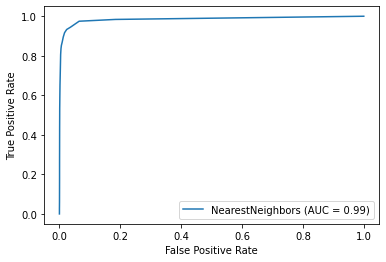

In [130]:
interval = (max_dist[1] - 0)/100
thresholds = np.arange(0, max_dist[1], interval)

FPR, TPR = [], []
F1 = []
pred_list = []

for thres in thresholds:
    pred = distances_.copy()
    pred[pred>=thres] = 1
    pred[pred<thres] = 0
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    fpr = (fp)/(fp+tn)
    tpr = (tp)/(tp+fn)
    FPR.append(fpr)
    TPR.append(tpr)
#     print(f"When threshold = {thres:.5f}, FPR: {fpr:.5f}  TPR: {tpr:.5f}")
    F1.append(f1_score(y_valid, pred))
    pred_list.append(pred)

FPR.append(0)
TPR.append(0)
roc_auc = auc(FPR, TPR)
display = RocCurveDisplay(fpr=FPR, tpr=TPR, roc_auc=roc_auc, estimator_name='NearestNeighbors')
display.plot()
plt.show()

The max f1 is: 0.9401522627943043
The best threshold is: 0.012407532096433216


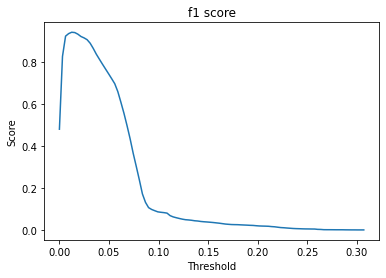

In [131]:
f1_max = np.array(F1).max()
print(f"The max f1 is: {f1_max}")
best_thres = thresholds[np.array(F1).argmax()]
print(f"The best threshold is: {best_thres}")
plt.plot(thresholds, F1)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("f1 score")
plt.show()

In [132]:
def print_metrics(model_name, y_test, y_pred):
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print ("Model Accuracy:" "\n", accuracy)
    print()
    classification = metrics.classification_report(y_test, y_pred)
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0, 1], display_labels=['Normal', 'Abormal'])
    # remove grid lines
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(visible=None)
    plt.show()


============================== NearestNeighbor Model Evaluation ==============================

Model Accuracy:
 0.9627137341423055

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     31029
           1       0.95      0.93      0.94     14296

    accuracy                           0.96     45325
   macro avg       0.96      0.96      0.96     45325
weighted avg       0.96      0.96      0.96     45325




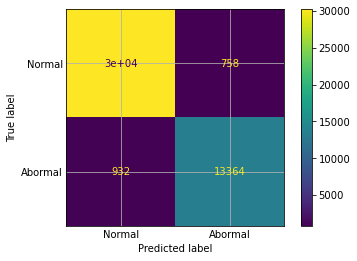

In [133]:
distances, _ = neigh.kneighbors(X_test)
distances_ = pd.Series([dist[0] for dist in distances])

y_pred = distances_.copy()
y_pred[y_pred>=best_thres] = 1
y_pred[y_pred<best_thres] = 0

print_metrics("NearestNeighbor", y_test, y_pred)

## Anomaly Detection (Gussian Mixture Model)

In [150]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)

# valid = X_valid.join(y_valid)

# X_test_normal = test[test.target == 0].drop(['target'],axis=1)
# X_test_attack = test[test.target == 1].drop(['target'],axis=1)

valid_normal_score = gmm.score(X_valid_normal)
valid_attack_score = gmm.score(X_valid_attack)

print(valid_normal_score)
print(valid_attack_score)

35.39252503184164
-24.106588929138212


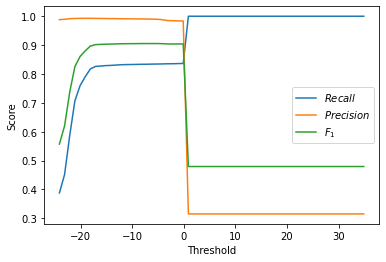

In [151]:
thresholds = np.arange(valid_attack_score, valid_normal_score, 1)

precision, recall, f1 = [], [], []

for thres in thresholds:
    valid_ss = gmm.score_samples(X_valid)
    pred = valid_ss.copy()
    pred[pred>=thres] = 0
    pred[pred<thres] = 1
    recall.append(recall_score(y_valid, pred))
    precision.append(precision_score(y_valid, pred))
    f1.append(f1_score(y_valid, pred))

plt.plot(thresholds, recall, label="$Recall$")
plt.plot(thresholds, precision, label="$Precision$")
plt.plot(thresholds, f1, label="$F_1$")
plt.legend(loc='best')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

The max f1 is: 0.9054397752723685
The best threshold is: -6.106588929138212


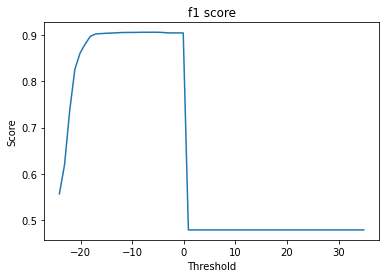

In [152]:
f1_max = np.array(f1).max()
print(f"The max f1 is: {f1_max}")
best_thres = thresholds[np.array(f1).argmax()]
print(f"The best threshold is: {best_thres}")
plt.plot(thresholds, f1)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("f1 score")
plt.show()


============================== GMM Model Evaluation ==============================

Model Accuracy:
 0.9442029784886927

Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     31029
           1       0.99      0.83      0.90     14296

    accuracy                           0.94     45325
   macro avg       0.96      0.91      0.93     45325
weighted avg       0.95      0.94      0.94     45325




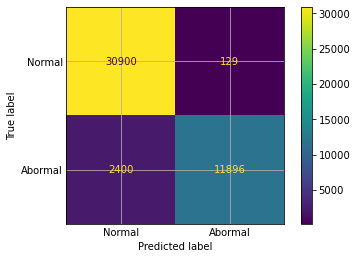

In [153]:
test_ss = gmm.score_samples(X_test)
test_pred = test_ss.copy()

test_pred[test_pred>=best_thres] = 0
test_pred[test_pred<best_thres] = 1

print_metrics("GMM", y_test, test_pred)

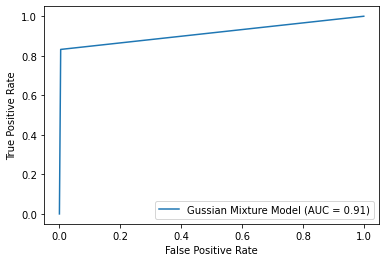

In [154]:
fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Gussian Mixture Model')
display.plot()
plt.show()

## Misuse Detection (Machine Learning Algorithms)

In [157]:
selected = ['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate', 'dst_host_diff_srv_rate', 'target']

df = pd.read_csv('./data_filter.csv')
df = df[selected]

In [158]:
# Use normalizer to normalize the features
from sklearn.preprocessing import normalize
X, y = df.iloc[:, :-1], df['target']
cols = X.columns
X = normalize(X)
X = pd.DataFrame(X, columns = cols)
df = X.join(y)

In [156]:
# df = pd.read_csv('./data_scaled_wbset10.csv')
df.describe()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_srv_serror_rate,dst_host_diff_srv_rate,target
count,235445.000000,235445.000000,2.354450e+05,2.354450e+05,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000,235445.000000
mean,28.063709,8.063654,2.731510e+03,3.616230e+03,29.503493,0.896692,0.024709,187.141260,0.042286,0.045090,0.121434
std,11.645892,2.425061,1.030929e+05,5.266818e+04,70.025935,0.287726,0.122158,98.500598,0.198595,0.144636,0.326632
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,9.000000,1.470000e+02,1.050000e+02,1.000000,1.000000,0.000000,106.000000,0.000000,0.000000,0.000000
50%,23.000000,9.000000,2.320000e+02,4.750000e+02,5.000000,1.000000,0.000000,255.000000,0.000000,0.000000,0.000000
75%,23.000000,9.000000,3.130000e+02,2.264000e+03,15.000000,1.000000,0.000000,255.000000,0.000000,0.030000,0.000000
max,66.000000,10.000000,2.441878e+07,7.068759e+06,511.000000,1.000000,1.000000,255.000000,1.000000,1.000000,1.000000


In [112]:
# 0 for normal conn., 1 for abnormal conn.
y = df['target']
X = df.drop(['target'], axis=1)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [113]:
def train_classifier(models, X_train, y_train, X_test, y_test):
    model_name, model = models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    classification = metrics.classification_report(y_test, y_pred)
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0, 1], display_labels=['Normal', 'Abnormal'])
    # remove grid lines
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(visible=None)
    plt.show()
    return y_pred


In [114]:
# function to plot roc curve
def plot_kfold_roc_curve(classifier,X,y,title):

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5)

    # defining the lists
    tprs = []
    aucs = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots(figsize=(8,6))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train].values.ravel())
        # Compute ROC curve and area under the curve (roc/auc)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {i}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        y_pred = classifier.predict(X.iloc[test])
        f1s.append(f1_score(y_true = y.iloc[test],y_pred = y_pred))
    print(f"average f1 score is: {sum(f1s)/len(f1s)}")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=title,
    )
    ax.legend(loc="lower right")
    plt.show()
    

### K Nearest Neighbors


============================== KNN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9964686829702988

Model Accuracy:
 0.9968853526630235

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62073
           1       0.99      0.98      0.99      8561

    accuracy                           1.00     70634
   macro avg       0.99      0.99      0.99     70634
weighted avg       1.00      1.00      1.00     70634




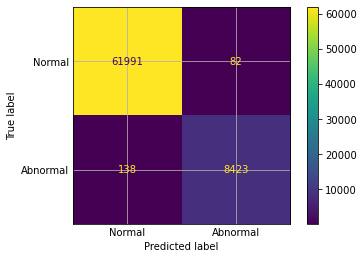

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [115]:
from sklearn.neighbors import KNeighborsClassifier

train_classifier(("KNN", KNeighborsClassifier(n_neighbors=7)), X_train, y_train, X_test, y_test)

average f1 score is: 0.9870592885951046


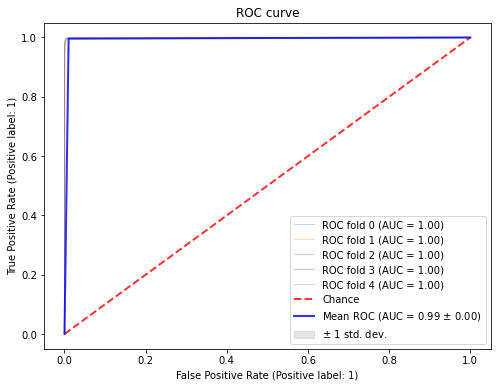

In [116]:
classifier = KNeighborsClassifier(n_neighbors=7)
plot_kfold_roc_curve(classifier, X, y, title = "ROC curve")